# Use Off-Policy VPG with Baseline to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

22:54:35 [INFO] env: <CartPoleEnv<CartPole-v0>>
22:54:35 [INFO] action_space: Discrete(2)
22:54:35 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
22:54:35 [INFO] reward_range: (-inf, inf)
22:54:35 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:54:35 [INFO] _max_episode_steps: 200
22:54:35 [INFO] _elapsed_steps: None


In [3]:
class OffPolicyVPGwBaselineAgent:
    def __init__(self, env,):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.06)
        self.baseline_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[])
        self.baseline_optimizer = optim.Adam(self.policy_net.parameters(), lr=0.1)
        self.baseline_loss = nn.MSELoss()

    def build_net(self, input_size, hidden_sizes, output_size=1,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train':
            action = np.random.choice(self.action_n) # use random policy
            self.trajectory += [observation, reward, done, action]
        else:
            state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
            prob_tensor = self.policy_net(state_tensor)
            action_tensor = distributions.Categorical(prob_tensor).sample()
            action = action_tensor.numpy()[0]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)

        # train baseline
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        return_tensor = discounted_return_tensor / discount_tensor
        pred_tensor = self.baseline_net(state_tensor)
        baseline_loss_tensor = self.baseline_loss(pred_tensor, return_tensor.unsqueeze(1))
        self.baseline_optimizer.zero_grad()
        baseline_loss_tensor.backward()
        self.baseline_optimizer.step()

        # train policy
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        behavior_prob = 1. / self.action_n
        policy_loss_tensor = -(discounted_return_tensor / behavior_prob * pi_tensor).mean()
        self.policy_optimizer.zero_grad()
        policy_loss_tensor.backward()
        self.policy_optimizer.step()


agent = OffPolicyVPGwBaselineAgent(env)

22:54:35 [INFO] ==== train ====
22:54:35 [DEBUG] train episode 0: reward = 39.00, steps = 39
22:54:35 [DEBUG] train episode 1: reward = 56.00, steps = 56
22:54:35 [DEBUG] train episode 2: reward = 61.00, steps = 61
22:54:35 [DEBUG] train episode 3: reward = 72.00, steps = 72
22:54:35 [DEBUG] train episode 4: reward = 45.00, steps = 45
22:54:35 [DEBUG] train episode 5: reward = 39.00, steps = 39
22:54:35 [DEBUG] train episode 6: reward = 28.00, steps = 28
22:54:35 [DEBUG] train episode 7: reward = 131.00, steps = 131
22:54:35 [DEBUG] train episode 8: reward = 15.00, steps = 15
22:54:35 [DEBUG] train episode 9: reward = 24.00, steps = 24
22:54:35 [DEBUG] train episode 10: reward = 51.00, steps = 51
22:54:35 [DEBUG] train episode 11: reward = 16.00, steps = 16
22:54:35 [DEBUG] train episode 12: reward = 15.00, steps = 15
22:54:35 [DEBUG] train episode 13: reward = 31.00, steps = 31
22:54:35 [DEBUG] train episode 14: reward = 66.00, steps = 66
22:54:35 [DEBUG] train episode 15: reward = 31

22:54:38 [DEBUG] train episode 129: reward = 68.00, steps = 68
22:54:38 [DEBUG] train episode 130: reward = 45.00, steps = 45
22:54:38 [DEBUG] train episode 131: reward = 77.00, steps = 77
22:54:38 [DEBUG] train episode 132: reward = 86.00, steps = 86
22:54:38 [DEBUG] train episode 133: reward = 46.00, steps = 46
22:54:38 [DEBUG] train episode 134: reward = 59.00, steps = 59
22:54:38 [DEBUG] train episode 135: reward = 37.00, steps = 37
22:54:38 [DEBUG] train episode 136: reward = 60.00, steps = 60
22:54:39 [DEBUG] train episode 137: reward = 51.00, steps = 51
22:54:39 [DEBUG] train episode 138: reward = 92.00, steps = 92
22:54:39 [DEBUG] train episode 139: reward = 70.00, steps = 70
22:54:39 [DEBUG] train episode 140: reward = 128.00, steps = 128
22:54:39 [DEBUG] train episode 141: reward = 57.00, steps = 57
22:54:39 [DEBUG] train episode 142: reward = 54.00, steps = 54
22:54:39 [DEBUG] train episode 143: reward = 91.00, steps = 91
22:54:39 [DEBUG] train episode 144: reward = 67.00, s

22:54:42 [DEBUG] train episode 257: reward = 86.00, steps = 86
22:54:42 [DEBUG] train episode 258: reward = 62.00, steps = 62
22:54:42 [DEBUG] train episode 259: reward = 46.00, steps = 46
22:54:42 [DEBUG] train episode 260: reward = 41.00, steps = 41
22:54:42 [DEBUG] train episode 261: reward = 77.00, steps = 77
22:54:42 [DEBUG] train episode 262: reward = 79.00, steps = 79
22:54:42 [DEBUG] train episode 263: reward = 51.00, steps = 51
22:54:42 [DEBUG] train episode 264: reward = 66.00, steps = 66
22:54:42 [DEBUG] train episode 265: reward = 43.00, steps = 43
22:54:42 [DEBUG] train episode 266: reward = 50.00, steps = 50
22:54:42 [DEBUG] train episode 267: reward = 78.00, steps = 78
22:54:42 [DEBUG] train episode 268: reward = 102.00, steps = 102
22:54:42 [DEBUG] train episode 269: reward = 38.00, steps = 38
22:54:42 [DEBUG] train episode 270: reward = 56.00, steps = 56
22:54:42 [DEBUG] train episode 271: reward = 44.00, steps = 44
22:54:42 [DEBUG] train episode 272: reward = 63.00, s

22:54:46 [DEBUG] train episode 385: reward = 72.00, steps = 72
22:54:46 [DEBUG] train episode 386: reward = 73.00, steps = 73
22:54:46 [DEBUG] train episode 387: reward = 66.00, steps = 66
22:54:46 [DEBUG] train episode 388: reward = 58.00, steps = 58
22:54:46 [DEBUG] train episode 389: reward = 61.00, steps = 61
22:54:46 [DEBUG] train episode 390: reward = 45.00, steps = 45
22:54:46 [DEBUG] train episode 391: reward = 60.00, steps = 60
22:54:46 [DEBUG] train episode 392: reward = 59.00, steps = 59
22:54:46 [DEBUG] train episode 393: reward = 43.00, steps = 43
22:54:46 [DEBUG] train episode 394: reward = 62.00, steps = 62
22:54:46 [DEBUG] train episode 395: reward = 36.00, steps = 36
22:54:46 [DEBUG] train episode 396: reward = 101.00, steps = 101
22:54:47 [DEBUG] train episode 397: reward = 63.00, steps = 63
22:54:47 [DEBUG] train episode 398: reward = 55.00, steps = 55
22:54:47 [DEBUG] train episode 399: reward = 83.00, steps = 83
22:54:47 [DEBUG] train episode 400: reward = 28.00, s

22:54:50 [DEBUG] train episode 513: reward = 87.00, steps = 87
22:54:50 [DEBUG] train episode 514: reward = 101.00, steps = 101
22:54:50 [DEBUG] train episode 515: reward = 64.00, steps = 64
22:54:50 [DEBUG] train episode 516: reward = 46.00, steps = 46
22:54:51 [DEBUG] train episode 517: reward = 63.00, steps = 63
22:54:51 [DEBUG] train episode 518: reward = 61.00, steps = 61
22:54:51 [DEBUG] train episode 519: reward = 64.00, steps = 64
22:54:51 [DEBUG] train episode 520: reward = 86.00, steps = 86
22:54:51 [DEBUG] train episode 521: reward = 45.00, steps = 45
22:54:51 [DEBUG] train episode 522: reward = 73.00, steps = 73
22:54:51 [DEBUG] train episode 523: reward = 116.00, steps = 116
22:54:51 [DEBUG] train episode 524: reward = 72.00, steps = 72
22:54:51 [DEBUG] train episode 525: reward = 66.00, steps = 66
22:54:51 [DEBUG] train episode 526: reward = 36.00, steps = 36
22:54:51 [DEBUG] train episode 527: reward = 62.00, steps = 62
22:54:51 [DEBUG] train episode 528: reward = 60.00,

22:54:55 [DEBUG] train episode 641: reward = 63.00, steps = 63
22:54:55 [DEBUG] train episode 642: reward = 76.00, steps = 76
22:54:55 [DEBUG] train episode 643: reward = 51.00, steps = 51
22:54:55 [DEBUG] train episode 644: reward = 58.00, steps = 58
22:54:55 [DEBUG] train episode 645: reward = 142.00, steps = 142
22:54:55 [DEBUG] train episode 646: reward = 72.00, steps = 72
22:54:55 [DEBUG] train episode 647: reward = 83.00, steps = 83
22:54:55 [DEBUG] train episode 648: reward = 60.00, steps = 60
22:54:55 [DEBUG] train episode 649: reward = 63.00, steps = 63
22:54:55 [DEBUG] train episode 650: reward = 59.00, steps = 59
22:54:55 [DEBUG] train episode 651: reward = 64.00, steps = 64
22:54:55 [DEBUG] train episode 652: reward = 61.00, steps = 61
22:54:55 [DEBUG] train episode 653: reward = 113.00, steps = 113
22:54:55 [DEBUG] train episode 654: reward = 69.00, steps = 69
22:54:55 [DEBUG] train episode 655: reward = 71.00, steps = 71
22:54:55 [DEBUG] train episode 656: reward = 134.00

22:55:00 [DEBUG] train episode 769: reward = 109.00, steps = 109
22:55:00 [DEBUG] train episode 770: reward = 95.00, steps = 95
22:55:00 [DEBUG] train episode 771: reward = 62.00, steps = 62
22:55:00 [DEBUG] train episode 772: reward = 74.00, steps = 74
22:55:00 [DEBUG] train episode 773: reward = 78.00, steps = 78
22:55:00 [DEBUG] train episode 774: reward = 81.00, steps = 81
22:55:01 [DEBUG] train episode 775: reward = 158.00, steps = 158
22:55:01 [DEBUG] train episode 776: reward = 78.00, steps = 78
22:55:01 [DEBUG] train episode 777: reward = 67.00, steps = 67
22:55:01 [DEBUG] train episode 778: reward = 137.00, steps = 137
22:55:01 [DEBUG] train episode 779: reward = 105.00, steps = 105
22:55:01 [DEBUG] train episode 780: reward = 51.00, steps = 51
22:55:01 [DEBUG] train episode 781: reward = 71.00, steps = 71
22:55:01 [DEBUG] train episode 782: reward = 61.00, steps = 61
22:55:01 [DEBUG] train episode 783: reward = 70.00, steps = 70
22:55:01 [DEBUG] train episode 784: reward = 46

22:55:06 [DEBUG] train episode 896: reward = 200.00, steps = 200
22:55:06 [DEBUG] train episode 897: reward = 79.00, steps = 79
22:55:06 [DEBUG] train episode 898: reward = 141.00, steps = 141
22:55:06 [DEBUG] train episode 899: reward = 75.00, steps = 75
22:55:06 [DEBUG] train episode 900: reward = 74.00, steps = 74
22:55:06 [DEBUG] train episode 901: reward = 96.00, steps = 96
22:55:06 [DEBUG] train episode 902: reward = 98.00, steps = 98
22:55:06 [DEBUG] train episode 903: reward = 103.00, steps = 103
22:55:06 [DEBUG] train episode 904: reward = 74.00, steps = 74
22:55:06 [DEBUG] train episode 905: reward = 59.00, steps = 59
22:55:06 [DEBUG] train episode 906: reward = 111.00, steps = 111
22:55:06 [DEBUG] train episode 907: reward = 79.00, steps = 79
22:55:06 [DEBUG] train episode 908: reward = 89.00, steps = 89
22:55:06 [DEBUG] train episode 909: reward = 112.00, steps = 112
22:55:06 [DEBUG] train episode 910: reward = 64.00, steps = 64
22:55:06 [DEBUG] train episode 911: reward = 

22:55:12 [DEBUG] train episode 1023: reward = 97.00, steps = 97
22:55:12 [DEBUG] train episode 1024: reward = 89.00, steps = 89
22:55:12 [DEBUG] train episode 1025: reward = 95.00, steps = 95
22:55:12 [DEBUG] train episode 1026: reward = 157.00, steps = 157
22:55:12 [DEBUG] train episode 1027: reward = 106.00, steps = 106
22:55:12 [DEBUG] train episode 1028: reward = 76.00, steps = 76
22:55:12 [DEBUG] train episode 1029: reward = 72.00, steps = 72
22:55:12 [DEBUG] train episode 1030: reward = 76.00, steps = 76
22:55:12 [DEBUG] train episode 1031: reward = 72.00, steps = 72
22:55:12 [DEBUG] train episode 1032: reward = 72.00, steps = 72
22:55:12 [DEBUG] train episode 1033: reward = 93.00, steps = 93
22:55:12 [DEBUG] train episode 1034: reward = 84.00, steps = 84
22:55:12 [DEBUG] train episode 1035: reward = 90.00, steps = 90
22:55:12 [DEBUG] train episode 1036: reward = 71.00, steps = 71
22:55:12 [DEBUG] train episode 1037: reward = 58.00, steps = 58
22:55:13 [DEBUG] train episode 1038:

22:55:18 [DEBUG] train episode 1149: reward = 69.00, steps = 69
22:55:18 [DEBUG] train episode 1150: reward = 79.00, steps = 79
22:55:18 [DEBUG] train episode 1151: reward = 75.00, steps = 75
22:55:18 [DEBUG] train episode 1152: reward = 76.00, steps = 76
22:55:18 [DEBUG] train episode 1153: reward = 155.00, steps = 155
22:55:18 [DEBUG] train episode 1154: reward = 104.00, steps = 104
22:55:18 [DEBUG] train episode 1155: reward = 77.00, steps = 77
22:55:18 [DEBUG] train episode 1156: reward = 80.00, steps = 80
22:55:18 [DEBUG] train episode 1157: reward = 87.00, steps = 87
22:55:18 [DEBUG] train episode 1158: reward = 78.00, steps = 78
22:55:18 [DEBUG] train episode 1159: reward = 64.00, steps = 64
22:55:18 [DEBUG] train episode 1160: reward = 71.00, steps = 71
22:55:18 [DEBUG] train episode 1161: reward = 150.00, steps = 150
22:55:18 [DEBUG] train episode 1162: reward = 58.00, steps = 58
22:55:19 [DEBUG] train episode 1163: reward = 98.00, steps = 98
22:55:19 [DEBUG] train episode 116

22:55:24 [DEBUG] train episode 1274: reward = 77.00, steps = 77
22:55:24 [DEBUG] train episode 1275: reward = 82.00, steps = 82
22:55:24 [DEBUG] train episode 1276: reward = 191.00, steps = 191
22:55:24 [DEBUG] train episode 1277: reward = 89.00, steps = 89
22:55:24 [DEBUG] train episode 1278: reward = 140.00, steps = 140
22:55:24 [DEBUG] train episode 1279: reward = 82.00, steps = 82
22:55:24 [DEBUG] train episode 1280: reward = 85.00, steps = 85
22:55:24 [DEBUG] train episode 1281: reward = 126.00, steps = 126
22:55:25 [DEBUG] train episode 1282: reward = 133.00, steps = 133
22:55:25 [DEBUG] train episode 1283: reward = 180.00, steps = 180
22:55:25 [DEBUG] train episode 1284: reward = 143.00, steps = 143
22:55:25 [DEBUG] train episode 1285: reward = 122.00, steps = 122
22:55:25 [DEBUG] train episode 1286: reward = 134.00, steps = 134
22:55:25 [DEBUG] train episode 1287: reward = 104.00, steps = 104
22:55:25 [DEBUG] train episode 1288: reward = 86.00, steps = 86
22:55:25 [DEBUG] train

22:55:32 [DEBUG] train episode 1398: reward = 72.00, steps = 72
22:55:32 [DEBUG] train episode 1399: reward = 95.00, steps = 95
22:55:32 [DEBUG] train episode 1400: reward = 161.00, steps = 161
22:55:32 [DEBUG] train episode 1401: reward = 112.00, steps = 112
22:55:32 [DEBUG] train episode 1402: reward = 99.00, steps = 99
22:55:33 [DEBUG] train episode 1403: reward = 90.00, steps = 90
22:55:33 [DEBUG] train episode 1404: reward = 97.00, steps = 97
22:55:33 [DEBUG] train episode 1405: reward = 123.00, steps = 123
22:55:33 [DEBUG] train episode 1406: reward = 174.00, steps = 174
22:55:33 [DEBUG] train episode 1407: reward = 179.00, steps = 179
22:55:33 [DEBUG] train episode 1408: reward = 150.00, steps = 150
22:55:33 [DEBUG] train episode 1409: reward = 143.00, steps = 143
22:55:33 [DEBUG] train episode 1410: reward = 132.00, steps = 132
22:55:33 [DEBUG] train episode 1411: reward = 133.00, steps = 133
22:55:33 [DEBUG] train episode 1412: reward = 119.00, steps = 119
22:55:33 [DEBUG] tra

22:55:41 [DEBUG] train episode 1521: reward = 113.00, steps = 113
22:55:41 [DEBUG] train episode 1522: reward = 130.00, steps = 130
22:55:42 [DEBUG] train episode 1523: reward = 200.00, steps = 200
22:55:42 [DEBUG] train episode 1524: reward = 149.00, steps = 149
22:55:42 [DEBUG] train episode 1525: reward = 178.00, steps = 178
22:55:42 [DEBUG] train episode 1526: reward = 153.00, steps = 153
22:55:42 [DEBUG] train episode 1527: reward = 180.00, steps = 180
22:55:42 [DEBUG] train episode 1528: reward = 167.00, steps = 167
22:55:42 [DEBUG] train episode 1529: reward = 139.00, steps = 139
22:55:42 [DEBUG] train episode 1530: reward = 127.00, steps = 127
22:55:42 [DEBUG] train episode 1531: reward = 181.00, steps = 181
22:55:42 [DEBUG] train episode 1532: reward = 104.00, steps = 104
22:55:42 [DEBUG] train episode 1533: reward = 130.00, steps = 130
22:55:42 [DEBUG] train episode 1534: reward = 121.00, steps = 121
22:55:43 [DEBUG] train episode 1535: reward = 135.00, steps = 135
22:55:43 [

22:55:51 [DEBUG] train episode 1644: reward = 160.00, steps = 160
22:55:51 [DEBUG] train episode 1645: reward = 96.00, steps = 96
22:55:51 [DEBUG] train episode 1646: reward = 129.00, steps = 129
22:55:51 [DEBUG] train episode 1647: reward = 109.00, steps = 109
22:55:51 [DEBUG] train episode 1648: reward = 137.00, steps = 137
22:55:51 [DEBUG] train episode 1649: reward = 178.00, steps = 178
22:55:51 [DEBUG] train episode 1650: reward = 102.00, steps = 102
22:55:51 [DEBUG] train episode 1651: reward = 129.00, steps = 129
22:55:51 [DEBUG] train episode 1652: reward = 158.00, steps = 158
22:55:51 [DEBUG] train episode 1653: reward = 97.00, steps = 97
22:55:51 [DEBUG] train episode 1654: reward = 129.00, steps = 129
22:55:51 [DEBUG] train episode 1655: reward = 119.00, steps = 119
22:55:51 [DEBUG] train episode 1656: reward = 141.00, steps = 141
22:55:52 [DEBUG] train episode 1657: reward = 186.00, steps = 186
22:55:52 [DEBUG] train episode 1658: reward = 115.00, steps = 115
22:55:52 [DEBU

22:56:00 [DEBUG] train episode 1767: reward = 144.00, steps = 144
22:56:00 [DEBUG] train episode 1768: reward = 122.00, steps = 122
22:56:00 [DEBUG] train episode 1769: reward = 181.00, steps = 181
22:56:00 [DEBUG] train episode 1770: reward = 200.00, steps = 200
22:56:00 [DEBUG] train episode 1771: reward = 172.00, steps = 172
22:56:01 [DEBUG] train episode 1772: reward = 166.00, steps = 166
22:56:01 [DEBUG] train episode 1773: reward = 146.00, steps = 146
22:56:01 [DEBUG] train episode 1774: reward = 200.00, steps = 200
22:56:01 [DEBUG] train episode 1775: reward = 150.00, steps = 150
22:56:01 [DEBUG] train episode 1776: reward = 200.00, steps = 200
22:56:01 [DEBUG] train episode 1777: reward = 191.00, steps = 191
22:56:01 [DEBUG] train episode 1778: reward = 130.00, steps = 130
22:56:01 [DEBUG] train episode 1779: reward = 163.00, steps = 163
22:56:01 [DEBUG] train episode 1780: reward = 200.00, steps = 200
22:56:01 [DEBUG] train episode 1781: reward = 200.00, steps = 200
22:56:01 [

22:56:12 [DEBUG] train episode 1890: reward = 186.00, steps = 186
22:56:12 [DEBUG] train episode 1891: reward = 127.00, steps = 127
22:56:12 [DEBUG] train episode 1892: reward = 157.00, steps = 157
22:56:12 [DEBUG] train episode 1893: reward = 200.00, steps = 200
22:56:12 [DEBUG] train episode 1894: reward = 156.00, steps = 156
22:56:13 [DEBUG] train episode 1895: reward = 200.00, steps = 200
22:56:13 [DEBUG] train episode 1896: reward = 190.00, steps = 190
22:56:13 [DEBUG] train episode 1897: reward = 159.00, steps = 159
22:56:13 [DEBUG] train episode 1898: reward = 160.00, steps = 160
22:56:13 [DEBUG] train episode 1899: reward = 120.00, steps = 120
22:56:13 [DEBUG] train episode 1900: reward = 115.00, steps = 115
22:56:13 [DEBUG] train episode 1901: reward = 200.00, steps = 200
22:56:13 [DEBUG] train episode 1902: reward = 200.00, steps = 200
22:56:13 [DEBUG] train episode 1903: reward = 145.00, steps = 145
22:56:13 [DEBUG] train episode 1904: reward = 193.00, steps = 193
22:56:14 [

22:56:25 [DEBUG] train episode 2013: reward = 200.00, steps = 200
22:56:25 [DEBUG] train episode 2014: reward = 180.00, steps = 180
22:56:25 [DEBUG] train episode 2015: reward = 146.00, steps = 146
22:56:25 [DEBUG] train episode 2016: reward = 171.00, steps = 171
22:56:25 [DEBUG] train episode 2017: reward = 141.00, steps = 141
22:56:25 [DEBUG] train episode 2018: reward = 143.00, steps = 143
22:56:25 [DEBUG] train episode 2019: reward = 200.00, steps = 200
22:56:25 [DEBUG] train episode 2020: reward = 200.00, steps = 200
22:56:25 [DEBUG] train episode 2021: reward = 185.00, steps = 185
22:56:25 [DEBUG] train episode 2022: reward = 125.00, steps = 125
22:56:25 [DEBUG] train episode 2023: reward = 174.00, steps = 174
22:56:26 [DEBUG] train episode 2024: reward = 153.00, steps = 153
22:56:26 [DEBUG] train episode 2025: reward = 162.00, steps = 162
22:56:26 [DEBUG] train episode 2026: reward = 178.00, steps = 178
22:56:26 [DEBUG] train episode 2027: reward = 160.00, steps = 160
22:56:26 [

22:56:35 [DEBUG] train episode 2136: reward = 178.00, steps = 178
22:56:36 [DEBUG] train episode 2137: reward = 169.00, steps = 169
22:56:36 [DEBUG] train episode 2138: reward = 151.00, steps = 151
22:56:36 [DEBUG] train episode 2139: reward = 117.00, steps = 117
22:56:36 [DEBUG] train episode 2140: reward = 170.00, steps = 170
22:56:36 [DEBUG] train episode 2141: reward = 110.00, steps = 110
22:56:36 [DEBUG] train episode 2142: reward = 200.00, steps = 200
22:56:36 [DEBUG] train episode 2143: reward = 125.00, steps = 125
22:56:36 [DEBUG] train episode 2144: reward = 140.00, steps = 140
22:56:36 [DEBUG] train episode 2145: reward = 107.00, steps = 107
22:56:36 [DEBUG] train episode 2146: reward = 119.00, steps = 119
22:56:36 [DEBUG] train episode 2147: reward = 125.00, steps = 125
22:56:36 [DEBUG] train episode 2148: reward = 132.00, steps = 132
22:56:36 [DEBUG] train episode 2149: reward = 160.00, steps = 160
22:56:36 [DEBUG] train episode 2150: reward = 111.00, steps = 111
22:56:36 [

22:56:46 [DEBUG] train episode 2259: reward = 109.00, steps = 109
22:56:46 [DEBUG] train episode 2260: reward = 119.00, steps = 119
22:56:46 [DEBUG] train episode 2261: reward = 155.00, steps = 155
22:56:47 [DEBUG] train episode 2262: reward = 185.00, steps = 185
22:56:47 [DEBUG] train episode 2263: reward = 129.00, steps = 129
22:56:47 [DEBUG] train episode 2264: reward = 120.00, steps = 120
22:56:47 [DEBUG] train episode 2265: reward = 119.00, steps = 119
22:56:47 [DEBUG] train episode 2266: reward = 123.00, steps = 123
22:56:47 [DEBUG] train episode 2267: reward = 149.00, steps = 149
22:56:47 [DEBUG] train episode 2268: reward = 101.00, steps = 101
22:56:47 [DEBUG] train episode 2269: reward = 128.00, steps = 128
22:56:47 [DEBUG] train episode 2270: reward = 121.00, steps = 121
22:56:47 [DEBUG] train episode 2271: reward = 110.00, steps = 110
22:56:47 [DEBUG] train episode 2272: reward = 96.00, steps = 96
22:56:47 [DEBUG] train episode 2273: reward = 145.00, steps = 145
22:56:47 [DE

22:56:56 [DEBUG] train episode 2382: reward = 157.00, steps = 157
22:56:56 [DEBUG] train episode 2383: reward = 113.00, steps = 113
22:56:56 [DEBUG] train episode 2384: reward = 144.00, steps = 144
22:56:56 [DEBUG] train episode 2385: reward = 140.00, steps = 140
22:56:56 [DEBUG] train episode 2386: reward = 130.00, steps = 130
22:56:56 [DEBUG] train episode 2387: reward = 150.00, steps = 150
22:56:57 [DEBUG] train episode 2388: reward = 94.00, steps = 94
22:56:57 [DEBUG] train episode 2389: reward = 144.00, steps = 144
22:56:57 [DEBUG] train episode 2390: reward = 200.00, steps = 200
22:56:57 [DEBUG] train episode 2391: reward = 93.00, steps = 93
22:56:57 [DEBUG] train episode 2392: reward = 108.00, steps = 108
22:56:57 [DEBUG] train episode 2393: reward = 112.00, steps = 112
22:56:57 [DEBUG] train episode 2394: reward = 103.00, steps = 103
22:56:57 [DEBUG] train episode 2395: reward = 108.00, steps = 108
22:56:57 [DEBUG] train episode 2396: reward = 171.00, steps = 171
22:56:57 [DEBU

22:57:07 [DEBUG] train episode 2505: reward = 189.00, steps = 189
22:57:07 [DEBUG] train episode 2506: reward = 113.00, steps = 113
22:57:07 [DEBUG] train episode 2507: reward = 167.00, steps = 167
22:57:07 [DEBUG] train episode 2508: reward = 140.00, steps = 140
22:57:07 [DEBUG] train episode 2509: reward = 92.00, steps = 92
22:57:07 [DEBUG] train episode 2510: reward = 156.00, steps = 156
22:57:08 [DEBUG] train episode 2511: reward = 125.00, steps = 125
22:57:08 [DEBUG] train episode 2512: reward = 130.00, steps = 130
22:57:08 [DEBUG] train episode 2513: reward = 200.00, steps = 200
22:57:08 [DEBUG] train episode 2514: reward = 200.00, steps = 200
22:57:08 [DEBUG] train episode 2515: reward = 159.00, steps = 159
22:57:08 [DEBUG] train episode 2516: reward = 103.00, steps = 103
22:57:08 [DEBUG] train episode 2517: reward = 113.00, steps = 113
22:57:08 [DEBUG] train episode 2518: reward = 117.00, steps = 117
22:57:08 [DEBUG] train episode 2519: reward = 118.00, steps = 118
22:57:08 [DE

22:57:18 [DEBUG] train episode 2628: reward = 123.00, steps = 123
22:57:18 [DEBUG] train episode 2629: reward = 114.00, steps = 114
22:57:18 [DEBUG] train episode 2630: reward = 200.00, steps = 200
22:57:18 [DEBUG] train episode 2631: reward = 148.00, steps = 148
22:57:18 [DEBUG] train episode 2632: reward = 132.00, steps = 132
22:57:18 [DEBUG] train episode 2633: reward = 101.00, steps = 101
22:57:18 [DEBUG] train episode 2634: reward = 200.00, steps = 200
22:57:19 [DEBUG] train episode 2635: reward = 138.00, steps = 138
22:57:19 [DEBUG] train episode 2636: reward = 167.00, steps = 167
22:57:19 [DEBUG] train episode 2637: reward = 200.00, steps = 200
22:57:19 [DEBUG] train episode 2638: reward = 167.00, steps = 167
22:57:19 [DEBUG] train episode 2639: reward = 141.00, steps = 141
22:57:19 [DEBUG] train episode 2640: reward = 200.00, steps = 200
22:57:19 [DEBUG] train episode 2641: reward = 143.00, steps = 143
22:57:19 [DEBUG] train episode 2642: reward = 155.00, steps = 155
22:57:19 [

22:57:30 [DEBUG] train episode 2751: reward = 200.00, steps = 200
22:57:30 [DEBUG] train episode 2752: reward = 168.00, steps = 168
22:57:31 [DEBUG] train episode 2753: reward = 195.00, steps = 195
22:57:31 [DEBUG] train episode 2754: reward = 200.00, steps = 200
22:57:31 [DEBUG] train episode 2755: reward = 193.00, steps = 193
22:57:31 [DEBUG] train episode 2756: reward = 200.00, steps = 200
22:57:31 [DEBUG] train episode 2757: reward = 185.00, steps = 185
22:57:31 [DEBUG] train episode 2758: reward = 200.00, steps = 200
22:57:31 [DEBUG] train episode 2759: reward = 180.00, steps = 180
22:57:31 [DEBUG] train episode 2760: reward = 192.00, steps = 192
22:57:32 [DEBUG] train episode 2761: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2762: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2763: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2764: reward = 200.00, steps = 200
22:57:32 [DEBUG] train episode 2765: reward = 200.00, steps = 200
22:57:32 [

22:57:43 [DEBUG] train episode 2874: reward = 200.00, steps = 200
22:57:43 [DEBUG] train episode 2875: reward = 156.00, steps = 156
22:57:43 [DEBUG] train episode 2876: reward = 167.00, steps = 167
22:57:43 [DEBUG] train episode 2877: reward = 104.00, steps = 104
22:57:43 [DEBUG] train episode 2878: reward = 189.00, steps = 189
22:57:43 [DEBUG] train episode 2879: reward = 147.00, steps = 147
22:57:43 [DEBUG] train episode 2880: reward = 143.00, steps = 143
22:57:43 [DEBUG] train episode 2881: reward = 161.00, steps = 161
22:57:43 [DEBUG] train episode 2882: reward = 121.00, steps = 121
22:57:43 [DEBUG] train episode 2883: reward = 152.00, steps = 152
22:57:43 [DEBUG] train episode 2884: reward = 103.00, steps = 103
22:57:44 [DEBUG] train episode 2885: reward = 186.00, steps = 186
22:57:44 [DEBUG] train episode 2886: reward = 142.00, steps = 142
22:57:44 [DEBUG] train episode 2887: reward = 123.00, steps = 123
22:57:44 [DEBUG] train episode 2888: reward = 198.00, steps = 198
22:57:44 [

22:57:53 [DEBUG] train episode 2997: reward = 129.00, steps = 129
22:57:53 [DEBUG] train episode 2998: reward = 200.00, steps = 200
22:57:53 [DEBUG] train episode 2999: reward = 200.00, steps = 200
22:57:54 [DEBUG] train episode 3000: reward = 200.00, steps = 200
22:57:54 [DEBUG] train episode 3001: reward = 166.00, steps = 166
22:57:54 [DEBUG] train episode 3002: reward = 152.00, steps = 152
22:57:54 [DEBUG] train episode 3003: reward = 200.00, steps = 200
22:57:54 [DEBUG] train episode 3004: reward = 200.00, steps = 200
22:57:54 [DEBUG] train episode 3005: reward = 188.00, steps = 188
22:57:54 [DEBUG] train episode 3006: reward = 175.00, steps = 175
22:57:54 [DEBUG] train episode 3007: reward = 144.00, steps = 144
22:57:54 [DEBUG] train episode 3008: reward = 200.00, steps = 200
22:57:55 [DEBUG] train episode 3009: reward = 191.00, steps = 191
22:57:55 [DEBUG] train episode 3010: reward = 126.00, steps = 126
22:57:55 [DEBUG] train episode 3011: reward = 200.00, steps = 200
22:57:55 [

22:58:05 [DEBUG] train episode 3120: reward = 138.00, steps = 138
22:58:05 [DEBUG] train episode 3121: reward = 158.00, steps = 158
22:58:05 [DEBUG] train episode 3122: reward = 154.00, steps = 154
22:58:05 [DEBUG] train episode 3123: reward = 150.00, steps = 150
22:58:06 [DEBUG] train episode 3124: reward = 129.00, steps = 129
22:58:06 [DEBUG] train episode 3125: reward = 185.00, steps = 185
22:58:06 [DEBUG] train episode 3126: reward = 200.00, steps = 200
22:58:06 [DEBUG] train episode 3127: reward = 163.00, steps = 163
22:58:06 [DEBUG] train episode 3128: reward = 125.00, steps = 125
22:58:06 [DEBUG] train episode 3129: reward = 200.00, steps = 200
22:58:06 [DEBUG] train episode 3130: reward = 200.00, steps = 200
22:58:06 [DEBUG] train episode 3131: reward = 134.00, steps = 134
22:58:06 [DEBUG] train episode 3132: reward = 200.00, steps = 200
22:58:06 [DEBUG] train episode 3133: reward = 194.00, steps = 194
22:58:06 [DEBUG] train episode 3134: reward = 168.00, steps = 168
22:58:06 [

22:58:15 [DEBUG] train episode 3243: reward = 200.00, steps = 200
22:58:15 [DEBUG] train episode 3244: reward = 200.00, steps = 200
22:58:15 [DEBUG] train episode 3245: reward = 124.00, steps = 124
22:58:15 [DEBUG] train episode 3246: reward = 200.00, steps = 200
22:58:15 [DEBUG] train episode 3247: reward = 200.00, steps = 200
22:58:15 [DEBUG] train episode 3248: reward = 155.00, steps = 155
22:58:15 [DEBUG] train episode 3249: reward = 168.00, steps = 168
22:58:15 [DEBUG] train episode 3250: reward = 187.00, steps = 187
22:58:15 [DEBUG] train episode 3251: reward = 200.00, steps = 200
22:58:15 [DEBUG] train episode 3252: reward = 192.00, steps = 192
22:58:15 [DEBUG] train episode 3253: reward = 195.00, steps = 195
22:58:15 [DEBUG] train episode 3254: reward = 180.00, steps = 180
22:58:16 [DEBUG] train episode 3255: reward = 200.00, steps = 200
22:58:16 [DEBUG] train episode 3256: reward = 187.00, steps = 187
22:58:16 [DEBUG] train episode 3257: reward = 200.00, steps = 200
22:58:16 [

22:58:24 [DEBUG] train episode 3366: reward = 178.00, steps = 178
22:58:24 [DEBUG] train episode 3367: reward = 200.00, steps = 200
22:58:24 [DEBUG] train episode 3368: reward = 153.00, steps = 153
22:58:24 [DEBUG] train episode 3369: reward = 120.00, steps = 120
22:58:24 [DEBUG] train episode 3370: reward = 176.00, steps = 176
22:58:24 [DEBUG] train episode 3371: reward = 200.00, steps = 200
22:58:24 [DEBUG] train episode 3372: reward = 173.00, steps = 173
22:58:24 [DEBUG] train episode 3373: reward = 179.00, steps = 179
22:58:24 [DEBUG] train episode 3374: reward = 200.00, steps = 200
22:58:24 [DEBUG] train episode 3375: reward = 141.00, steps = 141
22:58:24 [DEBUG] train episode 3376: reward = 127.00, steps = 127
22:58:25 [DEBUG] train episode 3377: reward = 176.00, steps = 176
22:58:25 [DEBUG] train episode 3378: reward = 200.00, steps = 200
22:58:25 [DEBUG] train episode 3379: reward = 122.00, steps = 122
22:58:25 [DEBUG] train episode 3380: reward = 178.00, steps = 178
22:58:25 [

22:58:32 [DEBUG] train episode 3489: reward = 194.00, steps = 194
22:58:33 [DEBUG] train episode 3490: reward = 167.00, steps = 167
22:58:33 [DEBUG] train episode 3491: reward = 172.00, steps = 172
22:58:33 [DEBUG] train episode 3492: reward = 200.00, steps = 200
22:58:33 [DEBUG] train episode 3493: reward = 180.00, steps = 180
22:58:33 [DEBUG] train episode 3494: reward = 172.00, steps = 172
22:58:33 [DEBUG] train episode 3495: reward = 190.00, steps = 190
22:58:33 [DEBUG] train episode 3496: reward = 200.00, steps = 200
22:58:33 [DEBUG] train episode 3497: reward = 152.00, steps = 152
22:58:33 [DEBUG] train episode 3498: reward = 200.00, steps = 200
22:58:33 [DEBUG] train episode 3499: reward = 151.00, steps = 151
22:58:33 [DEBUG] train episode 3500: reward = 200.00, steps = 200
22:58:33 [DEBUG] train episode 3501: reward = 200.00, steps = 200
22:58:34 [DEBUG] train episode 3502: reward = 200.00, steps = 200
22:58:34 [DEBUG] train episode 3503: reward = 143.00, steps = 143
22:58:34 [

22:58:41 [DEBUG] train episode 3612: reward = 104.00, steps = 104
22:58:41 [DEBUG] train episode 3613: reward = 126.00, steps = 126
22:58:41 [DEBUG] train episode 3614: reward = 145.00, steps = 145
22:58:41 [DEBUG] train episode 3615: reward = 144.00, steps = 144
22:58:41 [DEBUG] train episode 3616: reward = 126.00, steps = 126
22:58:41 [DEBUG] train episode 3617: reward = 169.00, steps = 169
22:58:41 [DEBUG] train episode 3618: reward = 190.00, steps = 190
22:58:42 [DEBUG] train episode 3619: reward = 111.00, steps = 111
22:58:42 [DEBUG] train episode 3620: reward = 127.00, steps = 127
22:58:42 [DEBUG] train episode 3621: reward = 144.00, steps = 144
22:58:42 [DEBUG] train episode 3622: reward = 187.00, steps = 187
22:58:42 [DEBUG] train episode 3623: reward = 177.00, steps = 177
22:58:42 [DEBUG] train episode 3624: reward = 141.00, steps = 141
22:58:42 [DEBUG] train episode 3625: reward = 154.00, steps = 154
22:58:42 [DEBUG] train episode 3626: reward = 115.00, steps = 115
22:58:42 [

22:58:48 [DEBUG] train episode 3735: reward = 125.00, steps = 125
22:58:48 [DEBUG] train episode 3736: reward = 144.00, steps = 144
22:58:48 [DEBUG] train episode 3737: reward = 104.00, steps = 104
22:58:49 [DEBUG] train episode 3738: reward = 161.00, steps = 161
22:58:49 [DEBUG] train episode 3739: reward = 103.00, steps = 103
22:58:49 [DEBUG] train episode 3740: reward = 200.00, steps = 200
22:58:49 [DEBUG] train episode 3741: reward = 111.00, steps = 111
22:58:49 [DEBUG] train episode 3742: reward = 128.00, steps = 128
22:58:49 [DEBUG] train episode 3743: reward = 96.00, steps = 96
22:58:49 [DEBUG] train episode 3744: reward = 126.00, steps = 126
22:58:49 [DEBUG] train episode 3745: reward = 106.00, steps = 106
22:58:49 [DEBUG] train episode 3746: reward = 125.00, steps = 125
22:58:49 [DEBUG] train episode 3747: reward = 119.00, steps = 119
22:58:49 [DEBUG] train episode 3748: reward = 107.00, steps = 107
22:58:49 [DEBUG] train episode 3749: reward = 166.00, steps = 166
22:58:49 [DE

22:58:55 [DEBUG] train episode 3858: reward = 158.00, steps = 158
22:58:55 [DEBUG] train episode 3859: reward = 194.00, steps = 194
22:58:56 [DEBUG] train episode 3860: reward = 200.00, steps = 200
22:58:56 [DEBUG] train episode 3861: reward = 145.00, steps = 145
22:58:56 [DEBUG] train episode 3862: reward = 200.00, steps = 200
22:58:56 [DEBUG] train episode 3863: reward = 169.00, steps = 169
22:58:56 [DEBUG] train episode 3864: reward = 140.00, steps = 140
22:58:56 [DEBUG] train episode 3865: reward = 156.00, steps = 156
22:58:56 [DEBUG] train episode 3866: reward = 133.00, steps = 133
22:58:56 [DEBUG] train episode 3867: reward = 178.00, steps = 178
22:58:56 [DEBUG] train episode 3868: reward = 154.00, steps = 154
22:58:56 [DEBUG] train episode 3869: reward = 192.00, steps = 192
22:58:56 [DEBUG] train episode 3870: reward = 141.00, steps = 141
22:58:56 [DEBUG] train episode 3871: reward = 179.00, steps = 179
22:58:56 [DEBUG] train episode 3872: reward = 136.00, steps = 136
22:58:56 [

22:59:02 [DEBUG] train episode 3981: reward = 148.00, steps = 148
22:59:02 [DEBUG] train episode 3982: reward = 120.00, steps = 120
22:59:02 [DEBUG] train episode 3983: reward = 200.00, steps = 200
22:59:03 [DEBUG] train episode 3984: reward = 187.00, steps = 187
22:59:03 [DEBUG] train episode 3985: reward = 151.00, steps = 151
22:59:03 [DEBUG] train episode 3986: reward = 129.00, steps = 129
22:59:03 [DEBUG] train episode 3987: reward = 194.00, steps = 194
22:59:03 [DEBUG] train episode 3988: reward = 124.00, steps = 124
22:59:03 [DEBUG] train episode 3989: reward = 162.00, steps = 162
22:59:03 [DEBUG] train episode 3990: reward = 111.00, steps = 111
22:59:03 [DEBUG] train episode 3991: reward = 200.00, steps = 200
22:59:03 [DEBUG] train episode 3992: reward = 128.00, steps = 128
22:59:03 [DEBUG] train episode 3993: reward = 180.00, steps = 180
22:59:03 [DEBUG] train episode 3994: reward = 102.00, steps = 102
22:59:03 [DEBUG] train episode 3995: reward = 119.00, steps = 119
22:59:03 [

22:59:09 [DEBUG] train episode 4104: reward = 169.00, steps = 169
22:59:09 [DEBUG] train episode 4105: reward = 150.00, steps = 150
22:59:09 [DEBUG] train episode 4106: reward = 161.00, steps = 161
22:59:10 [DEBUG] train episode 4107: reward = 154.00, steps = 154
22:59:10 [DEBUG] train episode 4108: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4109: reward = 159.00, steps = 159
22:59:10 [DEBUG] train episode 4110: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4111: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4112: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4113: reward = 170.00, steps = 170
22:59:10 [DEBUG] train episode 4114: reward = 166.00, steps = 166
22:59:10 [DEBUG] train episode 4115: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4116: reward = 200.00, steps = 200
22:59:10 [DEBUG] train episode 4117: reward = 159.00, steps = 159
22:59:10 [DEBUG] train episode 4118: reward = 200.00, steps = 200
22:59:10 [

22:59:17 [DEBUG] train episode 4227: reward = 200.00, steps = 200
22:59:17 [DEBUG] train episode 4228: reward = 133.00, steps = 133
22:59:17 [DEBUG] train episode 4229: reward = 136.00, steps = 136
22:59:17 [DEBUG] train episode 4230: reward = 198.00, steps = 198
22:59:17 [DEBUG] train episode 4231: reward = 153.00, steps = 153
22:59:17 [DEBUG] train episode 4232: reward = 187.00, steps = 187
22:59:17 [DEBUG] train episode 4233: reward = 200.00, steps = 200
22:59:17 [DEBUG] train episode 4234: reward = 200.00, steps = 200
22:59:17 [DEBUG] train episode 4235: reward = 169.00, steps = 169
22:59:18 [DEBUG] train episode 4236: reward = 200.00, steps = 200
22:59:18 [DEBUG] train episode 4237: reward = 139.00, steps = 139
22:59:18 [DEBUG] train episode 4238: reward = 158.00, steps = 158
22:59:18 [DEBUG] train episode 4239: reward = 173.00, steps = 173
22:59:18 [DEBUG] train episode 4240: reward = 155.00, steps = 155
22:59:18 [DEBUG] train episode 4241: reward = 200.00, steps = 200
22:59:18 [

22:59:24 [DEBUG] train episode 4350: reward = 135.00, steps = 135
22:59:24 [DEBUG] train episode 4351: reward = 167.00, steps = 167
22:59:24 [DEBUG] train episode 4352: reward = 120.00, steps = 120
22:59:24 [DEBUG] train episode 4353: reward = 136.00, steps = 136
22:59:24 [DEBUG] train episode 4354: reward = 200.00, steps = 200
22:59:24 [DEBUG] train episode 4355: reward = 134.00, steps = 134
22:59:24 [DEBUG] train episode 4356: reward = 157.00, steps = 157
22:59:25 [DEBUG] train episode 4357: reward = 182.00, steps = 182
22:59:25 [DEBUG] train episode 4358: reward = 200.00, steps = 200
22:59:25 [DEBUG] train episode 4359: reward = 182.00, steps = 182
22:59:25 [DEBUG] train episode 4360: reward = 200.00, steps = 200
22:59:25 [DEBUG] train episode 4361: reward = 137.00, steps = 137
22:59:25 [DEBUG] train episode 4362: reward = 200.00, steps = 200
22:59:25 [DEBUG] train episode 4363: reward = 130.00, steps = 130
22:59:25 [DEBUG] train episode 4364: reward = 182.00, steps = 182
22:59:25 [

22:59:31 [DEBUG] train episode 4473: reward = 158.00, steps = 158
22:59:31 [DEBUG] train episode 4474: reward = 200.00, steps = 200
22:59:31 [DEBUG] train episode 4475: reward = 132.00, steps = 132
22:59:31 [DEBUG] train episode 4476: reward = 109.00, steps = 109
22:59:31 [DEBUG] train episode 4477: reward = 130.00, steps = 130
22:59:31 [DEBUG] train episode 4478: reward = 200.00, steps = 200
22:59:31 [DEBUG] train episode 4479: reward = 134.00, steps = 134
22:59:31 [DEBUG] train episode 4480: reward = 132.00, steps = 132
22:59:31 [DEBUG] train episode 4481: reward = 114.00, steps = 114
22:59:31 [DEBUG] train episode 4482: reward = 196.00, steps = 196
22:59:31 [DEBUG] train episode 4483: reward = 135.00, steps = 135
22:59:31 [DEBUG] train episode 4484: reward = 118.00, steps = 118
22:59:31 [DEBUG] train episode 4485: reward = 121.00, steps = 121
22:59:31 [DEBUG] train episode 4486: reward = 96.00, steps = 96
22:59:32 [DEBUG] train episode 4487: reward = 124.00, steps = 124
22:59:32 [DE

22:59:37 [DEBUG] train episode 4596: reward = 189.00, steps = 189
22:59:37 [DEBUG] train episode 4597: reward = 141.00, steps = 141
22:59:38 [DEBUG] train episode 4598: reward = 157.00, steps = 157
22:59:38 [DEBUG] train episode 4599: reward = 128.00, steps = 128
22:59:38 [DEBUG] train episode 4600: reward = 127.00, steps = 127
22:59:38 [DEBUG] train episode 4601: reward = 146.00, steps = 146
22:59:38 [DEBUG] train episode 4602: reward = 115.00, steps = 115
22:59:38 [DEBUG] train episode 4603: reward = 173.00, steps = 173
22:59:38 [DEBUG] train episode 4604: reward = 157.00, steps = 157
22:59:38 [DEBUG] train episode 4605: reward = 158.00, steps = 158
22:59:38 [DEBUG] train episode 4606: reward = 200.00, steps = 200
22:59:38 [DEBUG] train episode 4607: reward = 148.00, steps = 148
22:59:38 [DEBUG] train episode 4608: reward = 179.00, steps = 179
22:59:38 [DEBUG] train episode 4609: reward = 143.00, steps = 143
22:59:38 [DEBUG] train episode 4610: reward = 138.00, steps = 138
22:59:38 [

22:59:45 [DEBUG] train episode 4719: reward = 183.00, steps = 183
22:59:45 [DEBUG] train episode 4720: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4721: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4722: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4723: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4724: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4725: reward = 193.00, steps = 193
22:59:45 [DEBUG] train episode 4726: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4727: reward = 191.00, steps = 191
22:59:45 [DEBUG] train episode 4728: reward = 200.00, steps = 200
22:59:45 [DEBUG] train episode 4729: reward = 200.00, steps = 200
22:59:46 [DEBUG] train episode 4730: reward = 200.00, steps = 200
22:59:46 [DEBUG] train episode 4731: reward = 200.00, steps = 200
22:59:46 [DEBUG] train episode 4732: reward = 200.00, steps = 200
22:59:46 [DEBUG] train episode 4733: reward = 200.00, steps = 200
22:59:46 [

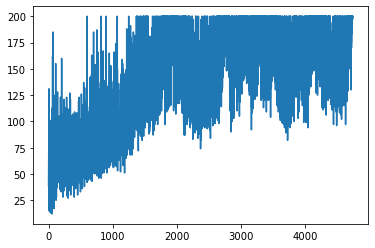

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()